<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/2_0_data_preparation_DSBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

_taken from [narrative seminar Osteoarthritis by Hunter & Bierma-Zeinstra (2019) in the Lancet](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf)._

Outcomes from total joint replacement can be optimised if patient selection identifies marked joint space narrowing. Most improvement will be made in patients with complete joint space loss and evident bone attrition. Up to 25% of patients presenting for total joint replacement continue to complain of pain and disability one year after (well-performed) surgery. Careful preoperative patient selection (including consideration of the poor outcomes that are more common in people who are depressed, have minimal radiographic disease, have minimal pain, and who are morbidly obese), shared decision making about surgery, and informing patients about realistic outcomes of surgery are needed to minimise the likelihood of dissatisfaction.

__Recap from previous lecture__
- Good outcome for knee replacement Y is measured using difference in Oxford Knee Score (OKS)
- Research has shown that an improvement in OKS score of approx. 30% is relevant ([van der Wees 2017](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/vanderwees2017patient-reported.pdf)). Hence an increase of +14 points is considered a 'good' outcome.
- to account for the ceiling effect, a high final `t1_oks_score` is also considered as a good outcome (even if `delta_oks_score` is smaller than 14).

# Data Preparation

This is day 2 from the [5-day JADS NHS PROMs data science case study](https://github.com/jads-nl/execute-nhs-proms/blob/master/README.md).



## Objectives Data Preparation

### Making the data 'tidy'

- Each variable must have its own column
- Each observation must have its own row
- Each value must have its own cell

### Selecting relevant information 

- Select appropriate observations 
- Select available features
- Select useful features

### Cleaning data

- Clean inconsistencies
- Handle missing data
- Setting appropriate data types

### Constructing data

- Define outcome Y (clustered classes, categories)
- Redefine and/or construct features (feature engineering)
- Decide if and how to handle correlated input features

## Importing data, libraries and style settings


In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, VarianceThreshold
from sklearn.model_selection import train_test_split
import sklearn.linear_model


#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# import data
df_raw = pd.read_parquet('https://github.com/jads-nl/execute-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

## Making the data 'tidy'

This is something that could take a lot of effort, but in our case we are lucky to be working with 'tidy' data already. 
* There is only one table to work with, so no merging or joining is needed
* Our rows correspond to the 'unit of analysis', just like we want them to
* Every column neatly contains one piece of information about our 'unit of analyses', so for every available replacement

## Selecting relevant information

Here we select the available features (at the intended moment of modeling) and the relevant features (i.e. we exclude the obviously irrelevant features such as IDs, telephone numbers for example), and select a subset of the rows if necessary.

In [2]:
# List all the available features
list(df_raw.columns)

['provider_code',
 'procedure',
 'revision_flag',
 'year',
 'age_band',
 'gender',
 't0_assisted',
 't0_assisted_by',
 't0_symptom_period',
 't0_previous_surgery',
 't0_living_arrangements',
 't0_disability',
 'heart_disease',
 'high_bp',
 'stroke',
 'circulation',
 'lung_disease',
 'diabetes',
 'kidney_disease',
 'nervous_system',
 'liver_disease',
 'cancer',
 'depression',
 'arthritis',
 't0_mobility',
 't0_self_care',
 't0_activity',
 't0_discomfort',
 't0_anxiety',
 't0_eq5d_index_profile',
 't0_eq5d_index',
 't1_assisted',
 't1_assisted_by',
 't1_living_arrangements',
 't1_disability',
 't1_mobility',
 't1_self_care',
 't1_activity',
 't1_discomfort',
 't1_anxiety',
 't1_satisfaction',
 't1_sucess',
 't1_allergy',
 't1_bleeding',
 't1_wound',
 't1_urine',
 't1_further_surgery',
 't1_readmitted',
 't1_eq5d_index_profile',
 't1_eq5d_index',
 'oks_eq_5d_index_t1_predicted',
 't0_eq_vas',
 't1_eq_vas',
 'oks_eq_vas_t1_predicted',
 'oks_t0_pain',
 'oks_t0_night_pain',
 'oks_t0_washing'

There are a number of `t1` variables that we cannot use at the time when we want the model to make a prediction, so we can exclude those variables from the analysis. For now we will leave in all the `t1` variables relating to the OKS that we will need when constructing our outcome Y. We will remove those after defining Y.

In [3]:
# remove columns
to_remove = ['t1_assisted', 't1_assisted_by', 't1_living_arrangements', 't1_disability', 't1_mobility', 't1_self_care',
             't1_activity', 't1_discomfort', 't1_anxiety', 't1_satisfaction', 't1_sucess', 't1_allergy', 't1_bleeding',
             't1_wound', 't1_urine', 't1_further_surgery', 't1_readmitted', 't1_eq5d_index_profile', 't1_eq5d_index']

df_temp = df_raw.drop(to_remove, axis=1)
list(df_temp.columns)

['provider_code',
 'procedure',
 'revision_flag',
 'year',
 'age_band',
 'gender',
 't0_assisted',
 't0_assisted_by',
 't0_symptom_period',
 't0_previous_surgery',
 't0_living_arrangements',
 't0_disability',
 'heart_disease',
 'high_bp',
 'stroke',
 'circulation',
 'lung_disease',
 'diabetes',
 'kidney_disease',
 'nervous_system',
 'liver_disease',
 'cancer',
 'depression',
 'arthritis',
 't0_mobility',
 't0_self_care',
 't0_activity',
 't0_discomfort',
 't0_anxiety',
 't0_eq5d_index_profile',
 't0_eq5d_index',
 'oks_eq_5d_index_t1_predicted',
 't0_eq_vas',
 't1_eq_vas',
 'oks_eq_vas_t1_predicted',
 'oks_t0_pain',
 'oks_t0_night_pain',
 'oks_t0_washing',
 'oks_t0_transport',
 'oks_t0_walking',
 'oks_t0_standing',
 'oks_t0_limping',
 'oks_t0_kneeling',
 'oks_t0_work',
 'oks_t0_confidence',
 'oks_t0_shopping',
 'oks_t0_stairs',
 'oks_t0_score',
 'oks_t1_pain',
 'oks_t1_night_pain',
 'oks_t1_washing',
 'oks_t1_transport',
 'oks_t1_walking',
 'oks_t1_standing',
 'oks_t1_limping',
 'oks_t1

In addition, domain experts deem a number of `t0` variables to be irrelevant:

In [4]:
# remove columns
to_remove_t0 = ['t0_assisted_by', 't0_eq5d_index_profile']

df_temp = df_temp.drop(to_remove_t0, axis=1)
list(df_temp.columns)

['provider_code',
 'procedure',
 'revision_flag',
 'year',
 'age_band',
 'gender',
 't0_assisted',
 't0_symptom_period',
 't0_previous_surgery',
 't0_living_arrangements',
 't0_disability',
 'heart_disease',
 'high_bp',
 'stroke',
 'circulation',
 'lung_disease',
 'diabetes',
 'kidney_disease',
 'nervous_system',
 'liver_disease',
 'cancer',
 'depression',
 'arthritis',
 't0_mobility',
 't0_self_care',
 't0_activity',
 't0_discomfort',
 't0_anxiety',
 't0_eq5d_index',
 'oks_eq_5d_index_t1_predicted',
 't0_eq_vas',
 't1_eq_vas',
 'oks_eq_vas_t1_predicted',
 'oks_t0_pain',
 'oks_t0_night_pain',
 'oks_t0_washing',
 'oks_t0_transport',
 'oks_t0_walking',
 'oks_t0_standing',
 'oks_t0_limping',
 'oks_t0_kneeling',
 'oks_t0_work',
 'oks_t0_confidence',
 'oks_t0_shopping',
 'oks_t0_stairs',
 'oks_t0_score',
 'oks_t1_pain',
 'oks_t1_night_pain',
 'oks_t1_washing',
 'oks_t1_transport',
 'oks_t1_walking',
 'oks_t1_standing',
 'oks_t1_limping',
 'oks_t1_kneeling',
 'oks_t1_work',
 'oks_t1_confiden

During data understanding, we saw that the data was scarce on patients in the oldest and youngest age-brackets. For the sake of the example, let's suppose that we decide to take these age-brackets out of scope, meaning we exclude these records from our data.

In [5]:
# describe age_band information
df_temp['age_band'].value_counts()

70 to 79     55056
60 to 69     45361
80 to 89     15883
50 to 59     13260
40 to 49       250
90 to 120       24
Name: age_band, dtype: int64

In [6]:
# exclude rows corresponding to the highest and lowest age-bracket
df_temp = df_temp.drop(df_temp[df_temp.age_band == "90 to 120"].index)
df_temp = df_temp.drop(df_temp[df_temp.age_band == "40 to 49"].index)
df_temp['age_band'].value_counts()

70 to 79     55056
60 to 69     45361
80 to 89     15883
50 to 59     13260
90 to 120        0
40 to 49         0
Name: age_band, dtype: int64

In [7]:
# unused levels should be removed to further clean / prepare the data
df_temp.age_band = df_temp.age_band.cat.remove_unused_categories()
df_temp['age_band'].value_counts()

70 to 79    55056
60 to 69    45361
80 to 89    15883
50 to 59    13260
Name: age_band, dtype: int64

## Cleaning Data

In this step we handle missing values, correct any inconsistencies found in the data and set the appropriate data types. 

We start off with a straightforward imputation strategy, where we impute 
* numerical variables with the median value, and
* categorical variables with the most occurring level

In [8]:
# First we map all the missings in the data
df_temp.isnull().sum()

provider_code                       0
procedure                           0
revision_flag                       0
year                                0
age_band                         9402
gender                           9402
t0_assisted                         0
t0_symptom_period                   0
t0_previous_surgery                 0
t0_living_arrangements              0
t0_disability                       0
heart_disease                       0
high_bp                             0
stroke                              0
circulation                         0
lung_disease                        0
diabetes                            0
kidney_disease                      0
nervous_system                      0
liver_disease                       0
cancer                              0
depression                          0
arthritis                           0
t0_mobility                         0
t0_self_care                        0
t0_activity                         0
t0_discomfor

Recall from the script on data understanding that there are a number of variables using a 9 to indicate a missing value. We need to identify those variables to be able to impute those 9s that actually refer to a missing value 

In [9]:
# list of all columns which contain 9s
cols_with_9 = [col for col in df_temp.columns if (df_temp[col]==9).any()]

# columns where 9 is *not* a sentinel value
comorb = ['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease', 'diabetes',
           'kidney_disease', 'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis']
cols_keep_9 = comorb + [ 't0_eq_vas', 't1_eq_vas','oks_t0_score', 'oks_t1_score']

# columns with 9 as sentinel value
cols_sentinel_9 = list(set(cols_with_9) ^ set(cols_keep_9))
df_temp[cols_sentinel_9].head(20)


,oks_t0_shopping,oks_t1_transport,oks_t0_limping,oks_t0_confidence,oks_t1_confidence,t0_disability,oks_t1_standing,t0_discomfort,oks_t0_work,oks_t1_pain,oks_t1_stairs,t0_activity,oks_t1_shopping,oks_t1_limping,t0_mobility,oks_t0_stairs,t0_living_arrangements,oks_t0_standing,oks_t0_washing,oks_t0_kneeling,oks_t1_work,t0_assisted,oks_t0_transport,t0_anxiety,t0_previous_surgery,oks_t0_walking,oks_t0_pain,oks_t1_night_pain,t0_self_care,oks_t1_washing,oks_t1_kneeling,oks_t1_walking,oks_t0_night_pain,t0_symptom_period
0,2,3,0,2,4,1,3,2,1,3,3,2,4,4,2,2,2,2,2,1,4,2,2,1,2,2,0,3,1,4,2,3,1,2
1,4,3,1,3,3,2,4,9,4,4,4,9,4,4,9,4,2,4,4,4,3,2,4,9,2,0,1,4,9,4,3,4,4,2
2,3,4,2,3,4,2,4,9,3,4,4,9,4,4,9,4,1,4,4,3,4,2,4,9,2,2,1,4,9,4,2,4,4,2
3,3,4,2,3,3,1,4,9,1,3,3,9,4,4,9,2,2,2,2,0,3,2,2,9,2,2,1,2,9,4,1,1,2,2
4,0,2,0,0,3,1,3,9,1,2,1,2,2,3,2,0,2,1,4,1,2,1,2,1,2,2,0,2,1,4,2,2,1,3
5,2,4,3,4,4,2,3,9,2,1,3,2,3,3,2,3,1,2,4,1,2,1,4,1,2,3,0,1,1,3,1,2,1,4
6,3,4,3,3,4,2,3,2,3,3,3,1,4,4,1,2,1,2,4,2,3,2,3,1,2,4,1,4,1,4,2,4,2,3
7,1,3,1,0,4,1,3,2,0,4,4,3,4,4,2,1,1,1,2,0,4,2,1,1,2,2,0,4,2,4,3,4,1,2
8,0,2,2,1,3,1,3,3,2,3,1,2,0,3,2,1,2,1,3,1,3,2,2,1,2,2,0,3,1,4,1,1,1,3
9,3,4,3,2,4,2,4,2,2,4,4,2,4,4,2,3,1,3,4,0,4,1,4,1,2,2,1,4,1,4,4,4,2,2


Now we are ready to impute the missings using the median (for numeric variables) and most frequent value (for categorical variables). However, we first need to be aware of so-called 'data-leaking': 

When we impute missing values using information from other data instances, we are also using information from data instances that will end up in our test set. This will give our process of model development an unfair advantage, and will result in an overly optimistic assessment of model performance. 

Even though the degree of data-leakage is very small when imputing using the median and the most frequent value, the correct thing to do is to first split the data into a training and test set.

In [10]:
# randomly splitting the data into a train and test set
df_train, df_test = train_test_split(df_temp, test_size=0.3, random_state=42)

Now we can impute the values in the training set, using the readily available functionality in the sklearn module. We work with a copy of the training data to be able to check our work and compare the imputed and not imputed versions of the data.

In [11]:
from sklearn.impute import SimpleImputer

impute_median = SimpleImputer(strategy='median')
impute_most_frequent = SimpleImputer(strategy='most_frequent')

# use copy of original data
dfc = df_train.copy()

# replace 9 with np.nan and determine most frequent value for imputation
dfc.loc[:,cols_sentinel_9] = df_train.loc[:,cols_sentinel_9].replace(9, np.nan)
impute_most_frequent.fit(dfc[cols_sentinel_9])
pd.DataFrame({'columns': cols_sentinel_9, 'most_frequent': impute_most_frequent.statistics_}).head(10)

,columns,most_frequent
0,oks_t0_shopping,2.0
1,oks_t1_transport,4.0
2,oks_t0_limping,0.0
3,oks_t0_confidence,1.0
4,oks_t1_confidence,4.0
5,t0_disability,1.0
6,oks_t1_standing,3.0
7,t0_discomfort,2.0
8,oks_t0_work,1.0
9,oks_t1_pain,3.0


All the 9s in the relevant columns have now been replaced by missings:

In [12]:
dfc[cols_sentinel_9].isnull().sum()

oks_t0_shopping            926
oks_t1_transport           857
oks_t0_limping             986
oks_t0_confidence          920
oks_t1_confidence          657
t0_disability             4111
oks_t1_standing            685
t0_discomfort             3851
oks_t0_work                941
oks_t1_pain                896
oks_t1_stairs              682
t0_activity               3112
oks_t1_shopping            691
oks_t1_limping             749
t0_mobility               2986
oks_t0_stairs              913
t0_living_arrangements    1473
oks_t0_standing           1009
oks_t0_washing              88
oks_t0_kneeling            973
oks_t1_work                718
t0_assisted               1076
oks_t0_transport           929
t0_anxiety                3574
t0_previous_surgery        735
oks_t0_walking            1004
oks_t0_pain                133
oks_t1_night_pain          614
t0_self_care              3062
oks_t1_washing             866
oks_t1_kneeling            738
oks_t1_walking             876
oks_t0_n

And these can now be imputed using the most frequent values:

In [13]:
# assign most frequent data to the missing values for the selected columns
dfc.loc[:, cols_sentinel_9] = impute_most_frequent.transform(dfc[cols_sentinel_9])

After which all the missings in these columns have been replaced:

In [14]:
dfc[cols_sentinel_9].isnull().sum()

oks_t0_shopping           0
oks_t1_transport          0
oks_t0_limping            0
oks_t0_confidence         0
oks_t1_confidence         0
t0_disability             0
oks_t1_standing           0
t0_discomfort             0
oks_t0_work               0
oks_t1_pain               0
oks_t1_stairs             0
t0_activity               0
oks_t1_shopping           0
oks_t1_limping            0
t0_mobility               0
oks_t0_stairs             0
t0_living_arrangements    0
oks_t0_standing           0
oks_t0_washing            0
oks_t0_kneeling           0
oks_t1_work               0
t0_assisted               0
oks_t0_transport          0
t0_anxiety                0
t0_previous_surgery       0
oks_t0_walking            0
oks_t0_pain               0
oks_t1_night_pain         0
t0_self_care              0
oks_t1_washing            0
oks_t1_kneeling           0
oks_t1_walking            0
oks_t0_night_pain         0
t0_symptom_period         0
dtype: int64

But these were not the only categorical variables with missing information. We have to do apply the same procedure to age_band and gender

In [15]:
dfc[['age_band', 'gender']].isnull().sum()

age_band    6564
gender      6564
dtype: int64

In [17]:
impute_most_frequent.fit(dfc[['age_band', 'gender']])
pd.DataFrame({'columns': ['age_band', 'gender'], 'most_frequent': impute_most_frequent.statistics_})

,columns,most_frequent
0,age_band,70 to 79
1,gender,2


In [18]:
# assign most frequent data to the missing values for the age and gender
dfc.loc[:, ['age_band', 'gender']] = impute_most_frequent.transform(dfc[['age_band', 'gender']])

In [19]:
# and our check:
dfc[['age_band', 'gender']].isnull().sum()

age_band    0
gender      0
dtype: int64

The eq_vas variables used 999 as sentinal values, so we can apply a similar procedure to these variables. As these variables contain numeric values, we use the median for imputation, rather than the most frequent value:

In [20]:
# same procedure for 999 sentinel values, using impute median
eq_vas = ['t0_eq_vas', 't1_eq_vas']
dfc.loc[:, eq_vas] = dfc.loc[:,eq_vas].replace(999, np.nan)
impute_median.fit(dfc.loc[:,eq_vas])
dfc.loc[:,eq_vas] = impute_median.transform(dfc.loc[:,eq_vas])
impute_median.statistics_

array([70., 80.])

In [21]:
dfc.isnull().sum()

provider_code                       0
procedure                           0
revision_flag                       0
year                                0
age_band                            0
gender                              0
t0_assisted                         0
t0_symptom_period                   0
t0_previous_surgery                 0
t0_living_arrangements              0
t0_disability                       0
heart_disease                       0
high_bp                             0
stroke                              0
circulation                         0
lung_disease                        0
diabetes                            0
kidney_disease                      0
nervous_system                      0
liver_disease                       0
cancer                              0
depression                          0
arthritis                           0
t0_mobility                         0
t0_self_care                        0
t0_activity                         0
t0_discomfor

There are still a few variables containing missings:
- t0_eq5d_index is a numeric variable which can be imputed using the median
- we will leave the missings in the t1_variables for now (oks_t1_score, oks_oks_t1_predicted, oks_eq_vas_t1_predicted and oks_eq_5d_index_t1_predicted)
- for the sake of the example, we can decide to exclude all instances where oks_t0_scores are missing, which has the implication that our model can only be applied in clinical practice to those patients for which oks_t0_scores are available.

In [22]:
# impute median for t0_eq5d_index
impute_median.fit(dfc.loc[:,'t0_eq5d_index'].to_frame())
dfc.loc[:,'t0_eq5d_index'] = impute_median.transform(dfc.loc[:,'t0_eq5d_index'].to_frame())
impute_median.statistics_

array([0.587], dtype=float32)

In [23]:
# remove instances with missing oks_t0_scores
dfc = dfc.dropna(subset=['oks_t0_score'])

## Convert data types

We now transform variables into the suitable data type, such that the data are in the proper format for building models.

In [24]:
# transform into boolean
dfc['female'] = dfc.loc[:,'gender'].replace({1: False, 2: True})
dfc.loc[:, comorb] = dfc.loc[:, comorb].replace({9: False, 1: True})
boolean = ['t0_assisted', 't0_previous_surgery', 't0_disability']
dfc.loc[:, boolean] = dfc.loc[:, boolean].replace({1: True, 2: False})

With the function below, we can describe how often True and False occurs within these boolean values: 

In [25]:
# helper function for counting boolean attribues
def count_boolean(series):
    '''
    Returns absolute and normalized value counts of pd.series as a dataframe with 
    index = series.name
    columns with absolute and normalized counts of each value
    '''
    try:
        count = series.value_counts().to_frame().transpose()
        norm = series.value_counts(normalize=True).to_frame().transpose()
        return count.join(norm, lsuffix='_count', rsuffix='_normalized') 
    except:
        print('Error: expecting a pandas.Series object as input. \n' + count_boolean.__doc__)
        return None

pd.concat([count_boolean(dfc[col]) for col in ['female'] + comorb + boolean]).round(2)

,True_count,False_count,True_normalized,False_normalized
female,57618,38503,0.60,0.40
heart_disease,8989,87132,0.09,0.91
high_bp,42691,53430,0.44,0.56
stroke,1562,94559,0.02,0.98
circulation,5393,90728,0.06,0.94
lung_disease,8813,87308,0.09,0.91
diabetes,12068,84053,0.13,0.87
kidney_disease,1970,94151,0.02,0.98
nervous_system,952,95169,0.01,0.99
liver_disease,551,95570,0.01,0.99


Finally, a few variables need to be defined as a categorical variable:

In [26]:
# convert to categories
dfc.loc[:, ['provider_code', 'age_band']] = dfc.loc[:, ['provider_code', 'age_band']].astype('category')

##Constructing data

Finally, we get the part where we make adjustments to the data:
- Defining the outcome Y
- Redefine and/or construct features (feature engineering, possibly handling correlated input features)

## Feature engineering

We start off with adding three simple features
- a variable representing total pain, which is the sum of 'pain' and 'night_pain', 
- a variable representing total functioning, which is the sum of the OKS-scores on all the non-pain dimensions, and
- a variable representing the total number of comorbidities

It is common to start simple and return to and put more effort into feature engineering if model performance is deemed insufficient

In [27]:
# define total pain and total number of comorbidities
def oks_questions(t='t0'):
  return [f'oks_{t}_pain', f'oks_{t}_night_pain', f'oks_{t}_washing',
          f'oks_{t}_transport', f'oks_{t}_walking', f'oks_{t}_standing',
          f'oks_{t}_limping', f'oks_{t}_kneeling', f'oks_{t}_work',
          f'oks_{t}_confidence', f'oks_{t}_shopping', f'oks_{t}_stairs', ]

for t in ("t0", "t1"):
    dfc[f"oks_{t}_pain_total"] = dfc[f"oks_{t}_pain"] + dfc[f"oks_{t}_night_pain"]
    dfc[f"oks_{t}_functioning_total"] = (
        dfc.loc[:, [col for col in oks_questions(t) if "pain" not in col]]
        .sum(axis=1)
    )
dfc["n_comorb"] = dfc.loc[:, comorb].sum()

## Selecting outcome Y

#### INTERMEZZO: we have already decided what outcome to choose, but this secions shows how you could approach defining an outcome measure based on the data (data-driven).

Figure 4 from the [narrative on outcomes of osteoarthritis](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf) states that the [European League Against Rheumatism (EULAR)](https://eular.org) standard considers three primary symptoms, namely:
- Hip/knee pain
- Early morning stiffness (EMS)
- Functional limitations

Comparing these with the [ICHOM standard set for hip & knee osteoarthritis](https://www.ichom.org/portfolio/hip-knee-osteoarthritis/) we take pain and functional limitations as the primary outcome parameters as ICHOM does not include EMS as a relevant outcome parameter. We now turn to the NHS dataset to choose which (engineered) features are available as a measure for pain and physical functioning at `t1`.

![](https://ichom.org/wp-content/uploads/2018/06/ichom_outcome_oa_3.jpg)

### Pain measures

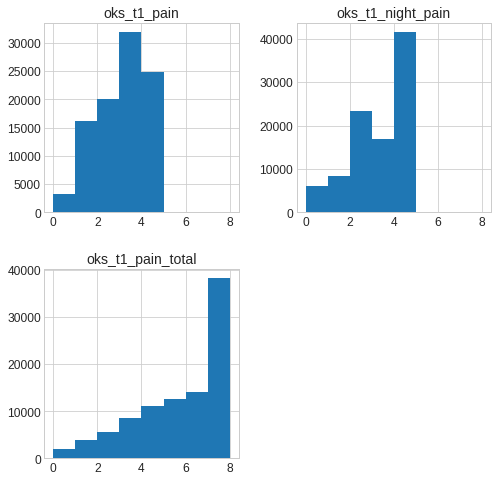

In [28]:
dfc[['oks_t1_pain', 'oks_t1_night_pain', 'oks_t1_pain_total']].hist(bins=range(0,9), figsize=S);

### Physical functioning

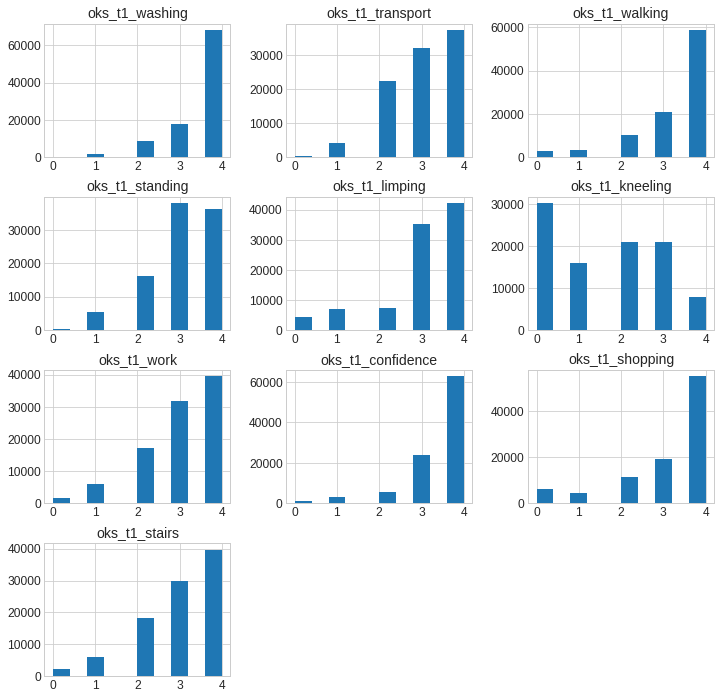

In [29]:
dfc.loc[:, [col for col in oks_questions("t1") if "pain" not in col],].hist(figsize=M);

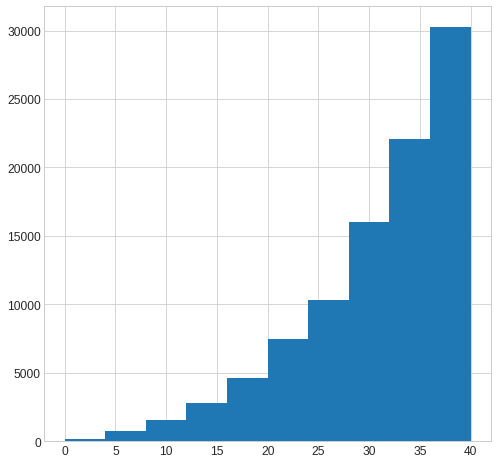

In [30]:
dfc['oks_t1_functioning_total'].hist(figsize=S);

### Combined outcome Y

Defining the appropriate outcome Y that meaningfully captures clinical change is a well-known challenge, see for example [development of psychometric tests](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/wise2004methods.pdf). 

Although this should always be defined with the help of domain experts, a data-driven approach to gather input on this decision could be to consider [the intersection between the 'pre' and 'post' histograms](http://blog.datadive.net/histogram-intersection-for-change-detection/), in this case pain and functioning measured at `t0` and `t1`.

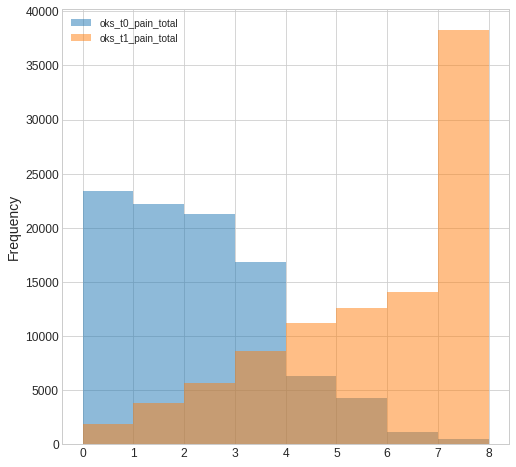

In [31]:
dfc[['oks_t0_pain_total', 'oks_t1_pain_total']].plot.hist(bins=range(0,9), alpha=0.5, figsize=S);

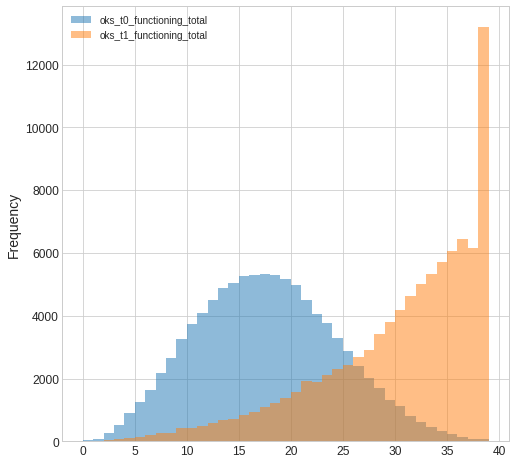

In [32]:
dfc[['oks_t0_functioning_total', 'oks_t1_functioning_total']].plot.hist(bins=range(0,40), alpha=0.5, figsize=S);

Using the histograms above, one way to combine pain and functioning into one outcome measure is to use the cut-off points:
- `oks_pain_total >= 4`: good outcome with less pain
- `oks_functioning_total >= 26`: good outcome with improved functioning

The figures below visualizes the combination of both measures to show that most people move from scoring poor on both pain and functioning at `t0` to scoring well on both of these measures at `t1`.

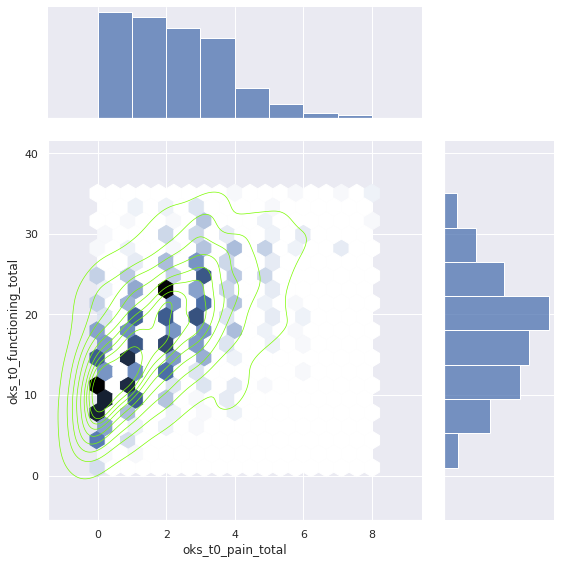

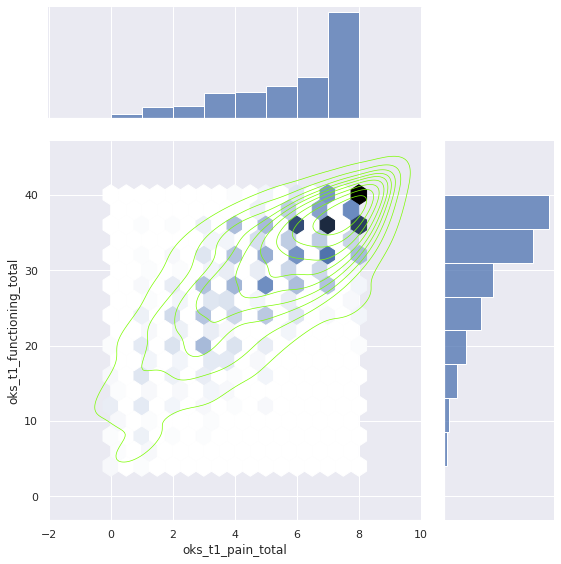

In [33]:
BINS = 8
SAMPLE = 1000

# https://stackoverflow.com/questions/45540886/reduce-line-width-of-seaborn-timeseries-plot
sns.set(rc={"lines.linewidth": 0.7})
fig1_layout = {
    'kind': "hex",
    'height': 8,
    'ratio': 3,
    'marginal_kws': {'bins': BINS, 'rug': False},
}
j1 = (sns.jointplot(
            'oks_t0_pain_total', 'oks_t0_functioning_total',
            data=dfc[['oks_t0_pain_total', 'oks_t0_functioning_total']].head(SAMPLE),
            **fig1_layout)
         .plot_joint(sns.kdeplot, color='lawngreen'))
j2 = (sns.jointplot(
            'oks_t1_pain_total', 'oks_t1_functioning_total',
            data=dfc[['oks_t1_pain_total', 'oks_t1_functioning_total']].head(SAMPLE), 
            **fig1_layout)
         .plot_joint(sns.kdeplot, color='lawngreen' ));

So let's add boolean columns indicating whether pain is 'good' (i.e. no pain) and functioning is good, both at `t0` and `t1`.

In [34]:
# add boolean columns
for t in ('t0', 't1'):
    dfc[f'y_{t}_pain_good'] = dfc[f'oks_{t}_pain_total'].apply(lambda s: True if s >= 4 else False)
    dfc[f'y_{t}_functioning_good'] = dfc[f'oks_{t}_functioning_total'].apply(lambda s: True if s >= 26 else False)

In [35]:
# inspect whether new features are correct
dfc[[col for col in dfc.columns if '_good' in col]].head(10)

,y_t0_pain_good,y_t0_functioning_good,y_t1_pain_good,y_t1_functioning_good
20950,False,False,False,False
42888,False,False,True,True
44064,False,False,True,False
62085,False,False,False,False
2309,False,False,True,True
21147,False,False,True,True
82117,False,False,True,True
108560,True,False,False,False
85423,False,False,False,False
83713,False,False,True,True


Using crosstabs we can visualize the percentage distributions on both measures

In [36]:
pd.crosstab(dfc.y_t0_pain_good, dfc.y_t0_functioning_good, normalize=True)

y_t0_functioning_good,False,True
y_t0_pain_good,,
False,0.81,0.07
True,0.08,0.05


In [37]:
pd.crosstab(dfc.y_t1_pain_good, dfc.y_t1_functioning_good, normalize=True)

y_t1_functioning_good,False,True
y_t1_pain_good,,
False,0.15,0.06
True,0.08,0.71


### Alternative outcome parameter

Another way to define the outcome measure is by looking at the improvement in oks_score and whether the oks_score at `t1` is above a certain threshold. The code below defines an outcome as good when the improvement in oks_score was larger than a minimum change threshold (chosen to be set at 13), OR when the absolute oks_score at `t1` was above a certain threshold (chosen to be set at 43). 

In [38]:
# add delta_oks_score and Y
def good_outcome(oks_t1, delta_oks, abs_threshold=43, mcid=13):
  if oks_t1 > abs_threshold or delta_oks > mcid:
    return True
  else:
    return False

dfc['delta_oks_score'] = dfc.oks_t1_score - dfc.oks_t0_score
dfc['Y'] = dfc.apply(lambda row: good_outcome(row['oks_t1_score'], row['delta_oks_score']), axis=1)
dfc.Y.value_counts(normalize=True)

True     0.66
False    0.34
Name: Y, dtype: float64

## Conclusion and reflection

The phase of data preparation worked through the following steps: 

### Making the data 'tidy'

- Each variable must have its own column
- Each observation must have its own row
- Each value must have its own cell

### Selecting relevant information 

- Select appropriate observations 
- Select available features
- Select useful features

### Cleaning data

- Clean inconsistencies
- Handle missing data
- Setting appropriate data types

### Constructing data

- Define outcome Y (clustered classes, categories)
- Redefine and/or construct features (feature engineering)
- Decide if and how to handle correlated input features


You should expect to be returning to this stage of data preparation multiple times, trying to tweak the data such that model performance can further improve. As such, always make sure to set up your script / workflow in such a way that adjustments can be easily made.

In [ ]:
# if you want to download the files to your local computer
#from google.colab import files
#dfc.to_csv('df_train.csv') 
#df_test.to_csv('df_test.csv')